# Polars: the real bear of dataframes!! 🐻‍❄️ <small>by Eran Krakovsky</small>

_DataFrame library written from scratch in Rust with An in memory query engine_

<div style="display:block;margin:0 auto;">
<img src="./polars-logo-python.svg" style="display:inline;margin-left:auto;margin-right:1em;width:20%" </img>
<img src="./polars-vs-pandas.png" style="display:inline;margin-left:auto;margin-right:auto;width:23%" </img>
</div>


### Goals
* Maximum runtime performance
* Composable functional API

### Topic

* Polars in a nutshell
* Expression language



## Why Polars?

1. Rustlang did not have a DataFrame library
2. Moore's law is ending
    - response: more cores.
    - numpy + pandas are single threaded and don't benefit from this hardware trend
3. Decades of database development (e.g.) query optimizations are not being used in python dataframe stack.
4. Python got its ass kicked by R datatable.


## Foundations

* **Rust programming language**: memory safe programming language 
    - performance == C/C++
    - Full control over memory / close to the metal
    - Fearless concurrency

* **Apache Arrow** as memory model
    - The future of big data communication and columnar store
    - Reduction of serialization/deserialization by standardizing and optimization of columnar memory.
    - within same process, data access is free (ptr sharing)
    
---
    
<div>
<img src="./arrow-logo.png" style="display:inline;margin-left:auto;margin-right:1em;width:30%" </img>
<img src="rust.svg" style="display:inline;margin:0 auto;width:24%" </img>
</div>



## Polars in a nutshell: 

* Column oriented data storage
    - No block manager -> predictable performance
* Copy on write semantics`
    - "Free" clones
    - Cheap appends
* Proper missing values: missing != `NaN`
* Efficient algorithms writting from scratch w/ for max. perf.
* Query optimizations
    - Expression folding
    - Predicate pushdown
    - Projection pushdown
    - Parallelization of physical plan
* SIMD vectorization

## Polars in a nutshell: Expressions + Query optimizations

* Lazy evaluation
    - Declarative
        - e.g. describe what you want, not how to do it
    - More context for optimizations
---

**declarative**
> ```
> get me a cup of coffee.
> ```

**procedural**
> ```
> take 5 steps of 75cm
> turn 90 degrees
> take 3 steps of 75cm
> take 1 step of 23cm
> turn 45 degrees
> lift your hand
> ...
> ...
> lower the coffee cup on the table
> ```

The latter has less room for optimization

## Polars in a nutshell: Blazingly fast 🚀🚀

source: https://www.pola.rs/benchmarks.html
### TPCH Benchmark
#### Results including reading parquet (lower is better)
<div>
<img src="https://raw.githubusercontent.com/pola-rs/polars-static/master/benchmarks/tpch/sf_10_and_io.png" width=100%>
</div>

#### Results starting from in-memory data (lower is better)
<div>
<img src="https://raw.githubusercontent.com/pola-rs/polars-static/master/benchmarks/tpch/sf_10.png" width=100%>
</div>



## Polars in a nutshell: Blazingly fast 🚀🚀

source: https://h2oai.github.io/db-benchmark/

<div>
<img src="./db-benchmark.png" width=700>
</div>

## Compared to Pandas

**performance**

* 5-20x runtime improvement

**memory requirements**
* pandas: ~10x dataset size
* polars: ~2-4x dataset size


In [1]:
import polars as pl
from polars import col, lit
import numpy as np
import pandas as pd

df = pl.DataFrame(
    {
        "A": [1, 2, 3, 4, 5],
        "fruits": ["banana", "banana", "apple", "apple", "banana"],
        "B": [5, 4, 3, 2, 1],
        "cars": ["beetle", "audi", "beetle", "beetle", "beetle"],
        "optional": [28, 300, None, 2, -30],
    }
)
df

A,fruits,B,cars,optional
i64,str,i64,str,i64
1,"""banana""",5,"""beetle""",28
2,"""banana""",4,"""audi""",300
3,"""apple""",3,"""beetle""",null
4,"""apple""",2,"""beetle""",2
5,"""banana""",1,"""beetle""",-30


## Pandas like Selection
* You can select colomns like in Pandas
* No indecies so selection of rows is done like pandas `iloc`

In [2]:
## pandas like col selection
df[2:5,['A','B','cars']]

A,B,cars
i64,i64,str
3,3,"""beetle"""
4,2,"""beetle"""
5,1,"""beetle"""


# Expressions

* `Fn(Series) -> Series`
    - expr output is input for another expr
    - Very composable expression language
    - can be combined indefinitetly
* Lazy evaluated
    - Optimizable 
* Reduces the need for custom (slow) python functions
* Embarrassingly parallel


---
    
They work differently depending on the context.

**Contexts**
* Selection
* Groupby

```python
# sum the column "foo"
df.select(pl.sum("foo"))

# sum values of "foo" grouped by "bar"
df.groupby("bar").agg(pl.sum("foo"))
```


## Selection context

* You can selection any value from a DataFrame.
* The data flowing through the expressions are columns in the `DataFrame`
* Every expression is evaluated in parallel.



In [3]:
# let's start simple

df.select([
    col("A"),                                      # select column "A" (syntactix sugar for `col("A")`)
    col("A").reverse().suffix("_reverse"),        # select column "A" -> reverse -> rename to "A_reverse"
])

A,A_reverse
i64,i64
1,5
2,4
3,3
4,2
5,1


In [4]:
# We select everything in normal order
# Then we select everything in reversed order
(df.select([
    pl.col("A"),
    pl.col("cars"),# we can also exclude/use regexes
    pl.all().reverse().suffix("_reverse")
]))

A,cars,A_reverse,fruits_reverse,B_reverse,cars_reverse,optional_reverse
i64,str,i64,str,i64,str,i64
1,"""beetle""",5,"""banana""",1,"""beetle""",-30
2,"""audi""",4,"""apple""",2,"""beetle""",2
3,"""beetle""",3,"""apple""",3,"""beetle""",null
4,"""beetle""",2,"""banana""",4,"""audi""",300
5,"""beetle""",1,"""banana""",5,"""beetle""",28


In [5]:
# We can also do aggregations
(df.select([
    pl.all().sum().suffix("_sum"),   # select all columns -> compute the sum -> add "_sum" to name
    pl.all().min().suffix("_min")    # select all columns -> compute the min -> add "_min" to name
]))

A_sum,fruits_sum,B_sum,cars_sum,optional_sum,A_min,fruits_min,B_min,cars_min,optional_min
i64,str,i64,str,i64,i64,str,i64,str,i64
15,null,15,null,300,1,"""apple""",1,"""audi""",-30


In [6]:
# Aggregation and normal projections can be combined
(df.select([
    col("A").rank().alias("rank_A"),   # select column "A" -> compute the rank -> rename to "rank_A"
    col("A").std().alias("A_std")      # select column "A" columns -> compute the std-dev -> rename to "A_std"
]))

rank_A,A_std
f32,f64
1.0,1.581139
2.0,1.581139
3.0,1.581139
4.0,1.581139
5.0,1.581139


## More on selecting columns

We can also select multiple columns by:
    
* regex: `col("^A.*$")`
* exclude columns: `pl.all().exclude("fruits")`
* dtypes: `col(pl.Utf8)`

## Filtering

In [7]:
# we can use simple filters

df.filter(col("fruits") == "banana")

A,fruits,B,cars,optional
i64,str,i64,str,i64
1,"""banana""",5,"""beetle""",28
2,"""banana""",4,"""audi""",300
5,"""banana""",1,"""beetle""",-30


In [8]:
eq_banana = col("fruits") == "banana"

(df.select([
    col("fruits").filter(eq_banana).count().alias("n_eq_banana"),
    col("A").filter(eq_banana).sum().alias("sum_A_eq_banana"),
]))

n_eq_banana,sum_A_eq_banana
u32,i64
3,8


In [9]:
# we can combine aggregations, filters, arithmetic and projection
df.select([
    "A",
    "B",
    "fruits",
    (col("A") + col("B")).alias("C"),
    col("A").mean().alias("A_mean"),
    col("B").filter(col("A") > 2).sum().alias("sum_a_gt_1"),
    col("B").filter(col("fruits") == "banana").sum().alias("sum_a=banana"),
    ((np.exp(col("B")) ** 2 + col("A").mean()) / 2).alias('arithmetic_result')
])

A,B,fruits,C,A_mean,sum_a_gt_1,sum_a=banana,arithmetic_result
i64,i64,str,i64,f64,i64,i64,f64
1,5,"""banana""",6,3.0,6,10,11014.732897
2,4,"""banana""",6,3.0,6,10,1491.978994
3,3,"""apple""",6,3.0,6,10,203.214397
4,2,"""apple""",6,3.0,6,10,28.799075
5,1,"""banana""",6,3.0,6,10,5.194528


In [10]:
# we can combine columns by a predicate

# pandas
df_pd = df.to_pandas()
df_pd["new"] = df_pd["B"]
df_pd.loc[df_pd["fruits"] != "banana","new"] = -1
print(df_pd)

# polars
df.with_columns(
    # similar to an if-else-expr
    pl.when(col("fruits") == "banana").then(col("B")).otherwise(-1).alias("new")
)

   A  fruits  B    cars  optional  new
0  1  banana  5  beetle      28.0    5
1  2  banana  4    audi     300.0    4
2  3   apple  3  beetle       NaN   -1
3  4   apple  2  beetle       2.0   -1
4  5  banana  1  beetle     -30.0    1


A,fruits,B,cars,optional,new
i64,str,i64,str,i64,i64
1,"""banana""",5,"""beetle""",28,5
2,"""banana""",4,"""audi""",300,4
3,"""apple""",3,"""beetle""",null,-1
4,"""apple""",2,"""beetle""",2,-1
5,"""banana""",1,"""beetle""",-30,1


In [11]:
# or we could keep combining predicates
df.with_columns(
    pl.when(col("fruits") == "banana")
    .then(col("B"))
    .when(col("fruits") == "apple")
    .then(12)
    .otherwise(-1).alias("new")
)

A,fruits,B,cars,optional,new
i64,str,i64,str,i64,i64
1,"""banana""",5,"""beetle""",28,5
2,"""banana""",4,"""audi""",300,4
3,"""apple""",3,"""beetle""",null,12
4,"""apple""",2,"""beetle""",2,12
5,"""banana""",1,"""beetle""",-30,1


```python
def pandas_some_function(df: pd.DataFrame) -> pd.DataFrame:
    # often seen and needed to write pure functions
    # but its very expensive
    df = df.clone()
    df["a"] = df["b"] + df["c"]
    return df
    
# all runs sequential
(pandas_df
    .pipe(pandas_some_function)
    .pipe(pandas_some_other_function)
)

def polars_some_function() -> pl.Expr:
    return col("b") + col("c").alias("a")
    
# sequential + parallel
(polars_df
     .with_column(foo_fn)
     .with_columns([bar_fn, ham_fn])  # parallel
     .select([
         polars_some_function(),      # parallel
         polars_some_other_function
         ...
         compute_bar()
     ])
)
```

## Groupby context

* syntax: `df.groupby(..).agg([exprs..])`
* The data flowing through the expressions are the groups of the groupby operation
* Every expression is evaluated in parallel.

In [12]:
(df.groupby("fruits")
 .agg([
     col("cars"),
     col("A")
 ])
)

fruits,cars,A
str,list[str],list[i64]
"""banana""","[""beetle"", ""audi"", ""beetle""]","[1, 2, 5]"
"""apple""","[""beetle"", ""beetle""]","[3, 4]"


In [13]:
(df.groupby("fruits")
 .agg([
     col("cars").filter(col("cars") == "beetle"),
     col("cars").filter(col("cars") == "beetle").count().alias("beetle_count"),
 ])
)

fruits,cars,beetle_count
str,list[str],u32
"""banana""","[""beetle"", ""beetle""]",2
"""apple""","[""beetle"", ""beetle""]",2


In [14]:
# Example of multiple aggregations in pandas
# however combining aggregations seems not possible? 

df_pd = df.to_pandas()
df_pd.groupby("fruits").agg({
    "A": ["shift", "sum"]
})

(df.groupby("fruits")
    .agg([
        (col("A").reverse().rolling_min(window_size=2) ** 2).alias("rolling_min_squared"),
        (col("A").reverse().rolling_min(window_size=2) ** 2).sum(),
    ])
)

fruits,rolling_min_squared,A
str,list[f64],f64
"""banana""","[null, 4.0, 1.0]",5.0
"""apple""","[null, 9.0]",9.0


# Window functions!

* Expression with superpowers.
* Aggregation in selection context
* Groupby over different columns


```python
col("foo").aggregation_expression(..).over("column_used_to_group")

col("foo").multiple_agg_exprs(..).over("column_used_to_group")
```

In [15]:
(df.sort("fruits")
 .select([
    "fruits",
    "cars",
     "A",
    col("A").apply(lambda x: x * 2).alias("a_new"),
    col("A").over("fruits", mapping_strategy="join").alias("group_lists_by_fruits"),    
    col("A").mean().over("cars").alias("mean_by_cars"),
    col("A").rank().over("fruits").flatten().alias("A_ranked_by_fruits"),
]))

fruits,cars,A,a_new,group_lists_by_fruits,mean_by_cars,A_ranked_by_fruits
str,str,i64,i64,list[i64],f64,f32
"""apple""","""beetle""",3,6,"[3, 4]",3.25,1.0
"""apple""","""beetle""",4,8,"[3, 4]",3.25,2.0
"""banana""","""beetle""",1,2,"[1, 2, 5]",3.25,1.0
"""banana""","""audi""",2,4,"[1, 2, 5]",2.0,2.0
"""banana""","""beetle""",5,10,"[1, 2, 5]",3.25,3.0


## True lazyness

In [16]:
df2 = pl.DataFrame({
    "fruits": ["banana", None, "apple"],
    "cars": ["audi", "beetle", None]
})

q = (df.lazy()
     .sort("fruits")
     .join(df2.lazy(), on="fruits")
     .filter(col("B") > 3)
     .select([
        "fruits",
        "cars",
        "B",
    ])
)

In [17]:
print(q.explain(optimized=False))

 SELECT [col("fruits"), col("cars"), col("B")] FROM
  FILTER [(col("B")) > (3)] FROM
  INNER JOIN:
  LEFT PLAN ON: [col("fruits")]
    SORT BY [col("fruits")]
      DF ["A", "fruits", "B", "cars"]; PROJECT */5 COLUMNS; SELECTION: "None"
  RIGHT PLAN ON: [col("fruits")]
    DF ["fruits", "cars"]; PROJECT */2 COLUMNS; SELECTION: "None"
  END INNER JOIN


In [18]:
print(q.explain(optimized=True))

FAST_PROJECT: [fruits, cars, B]
  INNER JOIN:
  LEFT PLAN ON: [col("fruits")]
    SORT BY [col("fruits")]
      DF ["A", "fruits", "B", "cars"]; PROJECT 3/5 COLUMNS; SELECTION: "[(col(\"B\")) > (3)]"
  RIGHT PLAN ON: [col("fruits")]
    DF ["fruits", "cars"]; PROJECT 2/2 COLUMNS; SELECTION: "None"
  END INNER JOIN


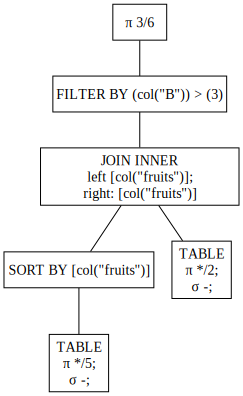

In [19]:
q.show_graph(optimized=False)

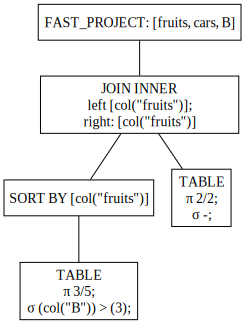

In [20]:
q.show_graph(optimized=True)

## Loading Data

In [ ]:
#add converation from parquest to csv because of gh limitaion
temp = pl.read_parquet(file)
temp.wri

In [29]:
%%time
file = 'data/mil.parquet'
pd_df = pd.read_parquet(file) #
pd_df.head()

CPU times: user 7.33 s, sys: 3.91 s, total: 11.2 s
Wall time: 7.8 s


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,None,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,None,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [30]:
%%time
pl_df = pl.read_parquet(file) ## load data to memory
pl_df.head()

CPU times: user 6.69 s, sys: 9.23 s, total: 15.9 s
Wall time: 6.86 s


event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
str,str,i64,i64,str,str,f64,i64,str
"""2019-10-01 00:…","""view""",44600062,2103807459595387724,null,"""shiseido""",35.79,541312140,"""72d76fde-8bb3-…"
"""2019-10-01 00:…","""view""",3900821,2053013552326770905,"""appliances.env…","""aqua""",33.2,554748717,"""9333dfbd-b87a-…"
"""2019-10-01 00:…","""view""",17200506,2053013559792632471,"""furniture.livi…",null,543.1,519107250,"""566511c2-e2e3-…"
"""2019-10-01 00:…","""view""",1307067,2053013558920217191,"""computers.note…","""lenovo""",251.74,550050854,"""7c90fc70-0e80-…"
"""2019-10-01 00:…","""view""",1004237,2053013555631882655,"""electronics.sm…","""apple""",1081.98,535871217,"""c6bd7419-2748-…"


In [31]:
%%time
pl_df_lz = pl.scan_parquet(file)# ## lazy load data
pl_df_lz.head().collect().to_pandas()

CPU times: user 22.1 ms, sys: 49.8 ms, total: 71.9 ms
Wall time: 70.7 ms


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,None,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,None,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


## SQL Context

In [24]:
%%time
file = 'data/mil.csv'
pl_df_dz = pl.scan_csv(file)# ## lazy load data
sql = pl.SQLContext()
sql.register('t', pl_df_dz)
sql.execute("SELECT user_id, SUM(price) AS price FROM t GROUP BY user_id ORDER BY price DESC").collect()

CPU times: user 4.71 s, sys: 1.56 s, total: 6.27 s
Wall time: 1.12 s


user_id,price
i64,f64
545614761,741797.02
513185778,687284.19
556342445,485826.36
555206577,472869.82
513519502,456009.05
513199113,447228.06
513117637,426581.16
514523084,426156.61
513068111,424140.03


## Final words

* Full lazy execution -> more optimizations
* Feature complete.
* Shoot!